# The code

In [1]:
import numpy as np
from astropy.timeseries import LombScargle
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from warnings import warn
from uncertainties import ufloat
import multiprocessing
#from tqdm.notebook import tqdm

class FourierFitter():        
    def func(self, time, amp, best_freq, phase, kind='sin'):
        # sin or cos funtion to be fitted
        if kind=='sin':
            y = amp*np.sin(2*np.pi*best_freq*time + phase )
        elif kind=='cos':
            y = amp*np.cos(2*np.pi*best_freq*time + phase )
        else:
            raise TypeError('%s format does not exist. Select \'sin\' or \'cos\'.' % str(kind))
        return y

    def fit_all(self, *arg):
        # fit all periodic components at the same time
        time = arg[0]
        best_freq = arg[1]
        nparams = (len(arg)-2)//2
        amps = arg[2:2+nparams]
        phases = arg[2+nparams:-1]
        kind = arg[-1]
        y = 0
        for i in range(len(amps)):
            y += self.func(time, amps[i], (i+1)*best_freq, phases[i],kind=kind)
        return y

    def bootstrap(self,seed):
        np.random.seed(seed)
        tmp_lc = self.lc[np.random.choice( self.lc.shape[0], int(len(self.lc)*self.sample_size), replace=False), :]
        if self.error is None: 
            tmp_pfit, _ = curve_fit(lambda *args: self.fit_all(*args, self.kind), tmp_lc[:,0], tmp_lc[:,1], p0=(self.freqs[0], *self.amps, *self.phases), maxfev=5000)
        else:
            tmp_pfit, _ = curve_fit(lambda *args: self.fit_all(*args, self.kind), tmp_lc[:,0], tmp_lc[:,1], p0=(self.freqs[0], *self.amps, *self.phases) , 
                              sigma=tmp_lc[:,2], absolute_sigma=self.absolute_sigma, maxfev=5000)
        
        return tmp_pfit

    def fit_freqs(self, t, y, error=None,
                  absolute_sigma=True,
                  nfreq = 3,plotting = False,
                  minimum_frequency=None,maximum_frequency=None,
                  nyquist_factor=1,samples_per_peak=10,
                  kind='sin',
                  bootstrap=False,ntry=100,sample_size=0.9,
                  parallel=False, ncores=-1,
                  refit=False):
        """
        ``fit_freqs`` performs Fourier pre-whitening and harmonic fitting.
        Parameters
        ----------
        t : array-like
            Time values of the light curve.
        y : array-like
            Flux/mag values of the light curve.
        error : array-like, optional
            Flux/mag errors values of the light curve. If not given, Fourier parameter
            errors will be less reliable.
        absolute_sigma : bool, default: True
            If `True`, error is used in an absolute sense and the estimated parameter covariance
            reflects these absolute values.
        nfreq : int, default: 3
            The number of harmonics to be fitted. Pass a very large number to fit all harmonics.
        plotting: bool, default: False
            If `True`, fitting steps will be displayed.
        minimum_frequency : float, optional
            If specified, then use this minimum frequency rather than one chosen based on the size
            of the baseline.
        maximum_frequency : float, optional
            If specified, then use this maximum frequency rather than one chosen based on the average
            nyquist frequency.
        nyquist_factor : float, default: 1
            The multiple of the average nyquist frequency used to choose the maximum frequency
            if ``maximum_frequency`` is not provided.
        samples_per_peak:  float, default: 10
            The approximate number of desired samples across the typical frequency peak.
        kind: str, 'sin' or 'cos'
            Harmonic function to be fitted.
        bootstrap: bool, default: False
            If `True`, boostrap method will be used to estimate parameter uncertainties.
        ntry: int, default: 100
            Number of resamplings for bootstrap error estimation.
        sample_size: float, default: 0.9
            The ratio of data points to be used for bootstrap error estimation in each step.
        parallel: bool, default : False
            If `True`, bootstrap sampling is performed parallel to speed up the process.
        ncores: int, default: -1
            Number of CPU cores to be used for parallel boostraping. If `-1`, then all available
            cores will be used.
        Returns
        -------
        pfit : array-like
            Array of fitted parameters. The main frequency, amplitude and phases of the harmonics.
        perr : array-like
            Estimated error of the parameters.
        """
        
        self.t = t
        self.y = y
        self.error = error
        self.sample_size = sample_size
        self.kind = kind
        self.absolute_sigma = absolute_sigma

        if minimum_frequency is not None and maximum_frequency is not None:
            if minimum_frequency > maximum_frequency:
                raise ValueError('Minimum frequency is larger than maximum frequency.')

        if nfreq<1:
            raise ValueError('Number of frequencies must be >1.')

        # fit periodic funtions and do prewhitening
        yres = self.y.copy()

        self.freqs = []
        self.amps = []
        self.phases = []
        self.freqserr = []
        self.ampserr = []
        self.phaseserr = []  

        for i in range(nfreq):
            if i == 0:
                ls = LombScargle(self.t, yres, nterms=1)
                freq, power = ls.autopower(normalization='psd',
                                           minimum_frequency=minimum_frequency,
                                           maximum_frequency=maximum_frequency,
                                           samples_per_peak=samples_per_peak,
                                           nyquist_factor=nyquist_factor)

                # get first spectrum and fit first periodic component
                try:
                    best_freq = freq[power.argmax()]

                    pfit1, pcov1 = curve_fit(lambda time, amp, phase: self.func(time, amp, best_freq, phase ,kind=kind), self.t, yres-np.mean(yres),
                                          p0=(np.ptp(yres)/4,2.), bounds=(0, [np.ptp(yres), 2*np.pi]) , 
                                          sigma=self.error, absolute_sigma=absolute_sigma, maxfev=5000)
                    pfit2, pcov2 = curve_fit(lambda time, amp, phase: self.func(time, amp, best_freq, phase ,kind=kind), self.t, yres-np.mean(yres),
                                          p0=(np.ptp(yres)/4,5.), bounds=(0, [np.ptp(yres), 2*np.pi]) , 
                                          sigma=self.error, absolute_sigma=absolute_sigma, maxfev=5000)

                    chi2_1 = np.sum( (yres-np.mean(yres) - self.func(self.t, pfit1[0], best_freq, pfit1[1] ,kind=kind))**2 )
                    chi2_2 = np.sum( (yres-np.mean(yres) - self.func(self.t, pfit2[0], best_freq, pfit2[1] ,kind=kind))**2 )

                    if chi2_1 < chi2_2:
                        pfit = pfit1
                    else:
                        pfit = pfit2

                    pfit, pcov = curve_fit(lambda time, amp, freq, phase: self.func(time, amp, freq, phase, kind=kind), self.t, yres-np.mean(yres),
                                          p0=(pfit[0],best_freq,pfit[1]), bounds=(0, [np.ptp(yres), 2*best_freq, 2*np.pi]) , 
                                          sigma=self.error, absolute_sigma=absolute_sigma, maxfev=5000)

                    best_freq = pfit[1]

                except (RuntimeError,ValueError) as e:
                    self.pfit = self.perr = [np.nan]*(nfreq*2+1)
                    return self.pfit, self.perr

            else:
                # --- Check if frequency is greater than Nyquist ---
                if (i+1)*best_freq > 0.5/np.median( np.diff(self.t) ):
                    # freq > Nyquist
                    warn('Frequency large than the Nyquist frequency!') 
                    
                # --- Check if max power is still above the noise level ---
                ls = LombScargle(self.t, yres, nterms=1)
                minf = (i+1)*best_freq-0.5
                if minf<0 : minf = 0
                freq, power = ls.autopower(normalization='psd',
                                           minimum_frequency=minf,
                                           maximum_frequency=(i+1)*best_freq+0.5,
                                           samples_per_peak=samples_per_peak)
                
                goodpts = np.isfinite(power)
                freq = freq[goodpts]
                power = power[goodpts]
                
                df = 1/np.ptp(self.t)
                umpeak = (freq > (i+1)*best_freq - df) & (freq < (i+1)*best_freq + df)
                if np.max(np.sqrt(power[umpeak])) <= np.mean(np.sqrt(power)) + 3*np.std(np.sqrt(power)):
                    # peak height < mean + 3 std
                    break
                    
                # --- Check if best period is longer than 2x data duration ---
                if np.allclose(freq[np.argmax(power)] ,0) or 0.5/freq[np.argmax(power)] < 1/np.ptp(self.t):
                    warn('Period is longer than 2x data duration!\nSet minimum frequency to avoid problems!\nSkipping...') 
                    break
                
                # --- get ith spectrum and fit ith periodic component ---
                pfit1, pcov1 = curve_fit(lambda time, amp, phase: self.func(time, amp, (i+1)*best_freq, phase, kind=kind), self.t, yres-np.mean(yres),
                                          p0=(np.ptp(yres)/4,2.), bounds=(0, [np.ptp(yres), 2*np.pi]) , 
                                          sigma=self.error, absolute_sigma=absolute_sigma, maxfev=5000)
                pfit2, pcov2 = curve_fit(lambda time, amp, phase: self.func(time, amp, (i+1)*best_freq, phase, kind=kind), self.t, yres-np.mean(yres),
                                          p0=(np.ptp(yres)/4,5.), bounds=(0, [np.ptp(yres), 2*np.pi]) , 
                                          sigma=self.error, absolute_sigma=absolute_sigma, maxfev=5000)

                chi2_1 = np.sum( (yres-np.mean(yres) - self.func(self.t, pfit1[0], (i+1)*best_freq, pfit1[1], kind=kind ))**2 )
                chi2_2 = np.sum( (yres-np.mean(yres) - self.func(self.t, pfit2[0], (i+1)*best_freq, pfit2[1], kind=kind ))**2 )

                if chi2_1 < chi2_2:
                    pfit = pfit1
                    pcov = pcov1
                else:
                    pfit = pfit2
                    pcov = pcov2

            if plotting:
                # plot phased light curve and fit
                if i==0:
                    per = 1/pfit[1]
                else:
                    per = 1/( (i+1)*best_freq )
                    
                    # Calculate spectrum for plotting
                    ls = LombScargle(self.t, yres, nterms=1)
                    freq, power = ls.autopower(normalization='psd',
                                               minimum_frequency=minimum_frequency,
                                               maximum_frequency=maximum_frequency,
                                               samples_per_peak=samples_per_peak,
                                               nyquist_factor=nyquist_factor)
                        
                plt.figure(figsize=(15,3))
                plt.subplot(121)
                plt.plot(freq, power)
                plt.xlabel('Frequency (c/d)')
                plt.ylabel('LS power')
                plt.grid()
                plt.subplot(122)
                plt.plot(self.t%per/per,yres-yres.mean(),'k.')
                plt.plot(self.t%per/per+1,yres-yres.mean(),'k.')
                if i == 0:
                    plt.plot(self.t%per/per,self.func(self.t,pfit[0],pfit[1],pfit[2], kind=kind),'C1.',ms=1)
                    plt.plot(self.t%per/per+1,self.func(self.t,pfit[0],pfit[1],pfit[2], kind=kind),'C1.',ms=1)
                else:
                    plt.plot(self.t%per/per,self.func(self.t,pfit[0],(i+1)*best_freq,pfit[1], kind=kind),'C1.',ms=1)
                    plt.plot(self.t%per/per+1,self.func(self.t,pfit[0],(i+1)*best_freq,pfit[1], kind=kind),'C1.',ms=1)
                plt.xlabel('Phase)')
                plt.ylabel('Brightness')
                plt.show()

            if i==0:
                # start to collect results
                self.freqs.append( pfit[1] )
                self.amps.append( pfit[0] )
                self.phases.append( pfit[2] )

                pcov = np.sqrt(np.diag(pcov))
                self.freqserr.append( pcov[1] )
                self.ampserr.append( pcov[0] )
                self.phaseserr.append( pcov[2] )

                yres -= self.func(self.t,pfit[0],pfit[1],pfit[2], kind=kind)
            else:
                # collect ith results
                self.freqs.append( (i+1)*best_freq )
                self.amps.append( pfit[0] )
                self.phases.append( pfit[1] )

                pcov = np.sqrt(np.diag(pcov))
                self.freqserr.append( self.freqserr[0] )
                self.ampserr.append( pcov[0] )
                self.phaseserr.append( pcov[1] )

                yres -= self.func(self.t,pfit[0],(i+1)*best_freq,pfit[1], kind=kind)

        try: 
            # fit all periodic components at the same time
            pfit, pcov = curve_fit(lambda *args: self.fit_all(*args, kind), self.t, self.y-np.mean(self.y),p0=(self.freqs[0], *self.amps, *self.phases) , 
                                    sigma=self.error, absolute_sigma=absolute_sigma, maxfev=5000)
            
            # if any of the errors is inf, shift light curve by period/2 and get new errors
            if not bootstrap and np.any(np.isinf(pcov)):
                warn('One of the errors is inf! Shifting light curve by half period to calculate errors...')
                _, pcov = curve_fit(lambda *args: self.fit_all(*args, kind), self.t + 0.5/pfit[0], self.y-np.mean(self.y),p0=(self.freqs[0], *self.amps, *[(pha+np.pi)%(2*np.pi) for pha in self.phases]) , 
                                    sigma=self.error, absolute_sigma=absolute_sigma, maxfev=5000)

            if bootstrap and refit is False:
                # use bootstrap to get realistic errors (bootstrap = get subsample and redo fit n times)
                if self.error is None: self.lc = np.c_[self.t, self.y-np.mean(self.y)]
                else:                  self.lc = np.c_[self.t, self.y-np.mean(self.y), self.error]

                bootstrap_fit = np.empty( (ntry,len(pfit)) )
                seeds = np.random.randint(1e09,size=ntry)
                if parallel:
                    # do bootstrap fit parallal
                    available_ncores = multiprocessing.cpu_count()
                    if ncores <= -1:
                        ncores = available_ncores
                    elif available_ncores<ncores:
                        ncores = available_ncores
                    with multiprocessing.Pool(processes=ncores) as p:
                        #with tqdm(total=ntry) as pbar:
                        for i,result in enumerate(p.imap_unordered(self.bootstrap,seeds)):
                            # Save result
                            bootstrap_fit[i,:] = result
                            #pbar.update()
                else:
                    for i,seed in enumerate(seeds):
                        bootstrap_fit[i,:] = self.bootstrap(seed)

                #meanval = np.nanmean(bootstrap_fit,axis=0)
                perr = np.nanstd(bootstrap_fit,axis=0)

                if np.any(perr == 0.0):
                    # if any of the errors is 0, shift light curve by period/2 and get new errors
                    warn('One of the errors is too small! Shifting light curve by half period to calculate errors...')

                    _,newperr = self.fit_freqs(self.t + 0.5/pfit[0], self.y-np.mean(self.y), nfreq = nfreq,plotting = False,
                                  minimum_frequency=minimum_frequency,maximum_frequency=maximum_frequency,
                                  nyquist_factor=nyquist_factor,samples_per_peak=samples_per_peak,
                                  bootstrap=True,ntry=ntry,sample_size=self.sample_size,
                                  refit=True)

                    try:
                        um = np.where( perr==0.0 )[0]
                        perr[um] = np.copy(newperr[um])
                    except IndexError:
                        pass
                    self.pfit = pfit
                    self.perr = perr
                    return self.pfit, self.perr

                self.pfit = pfit
                self.perr = perr
                return self.pfit, self.perr

            elif bootstrap and refit:
                # get new errors for shifted light curve
                if self.error is None: lc = np.c_[self.t, self.y-np.mean(y)]
                else:                  lc = np.c_[self.t, self.y-np.mean(y), self.error]

                bootstrap_fit = np.empty( (ntry,len(pfit)) )
                seeds = np.random.randint(1e09,size=ntry)
                if parallel:
                    # do bootstrap fit parallal
                    available_ncores = multiprocessing.cpu_count()
                    if ncores <= -1:
                        ncores = available_ncores
                    elif available_ncores<ncores:
                        ncores = available_ncores
                    with multiprocessing.Pool(processes=ncores) as p:
                        #with tqdm(total=ntry) as pbar:
                        for i,result in enumerate(p.imap_unordered(self.bootstrap,seeds)):
                            # Save result
                            bootstrap_fit[i,:] = result
                            #pbar.update()
                else:
                    for i,seed in enumerate(seeds):
                        bootstrap_fit[i,:] = self.bootstrap(seed)

                #meanval = np.nanmean(bootstrap_fit,axis=0)
                newperr = np.nanstd(bootstrap_fit,axis=0)

                self.pfit = pfit
                self.perr = newperr
                return self.pfit, self.perr

            self.pfit = pfit
            self.perr = np.sqrt(np.diag(pcov))
            return self.pfit, self.perr

        except RuntimeError:
            # if fit all components at once fails return previous results, and errors from covariance matrix
            if bootstrap:
                warn('BootStrap not used!')

            self.pfit = np.array([self.freqs[0], *self.amps, *self.phases])
            self.perr = np.array([self.freqserr[0], *self.ampserr, *self.phaseserr])
            return self.pfit, self.perr

    def get_fourier_parameters(self):
        """
        Calculates Fourier parameters from given amplitudes and phases.
  
        Returns
        -------
        freq : number with uncertainty
            Main frequency and its estimated error.
        period : 
            Main period and its estimated error.
        P21 : number with uncertainty
            Phi21 and its estimated error.
        P31 : number with uncertainty
            Phi31 and its estimated error.
        R21 : number with uncertainty
            R21 and its estimated error.
        R31 : number with uncertainty
            R31 and its estimated error.
        """
        if np.all(np.isnan(self.pfit)) or len(self.pfit)<6:
            warn('Not enough components to get Fourier parameters!') 
            #raise ValueError('Not enough components to get Fourier parameters!') 
            
            freq = ufloat(np.nan,np.nan)
            period = np.nan
            R21 = ufloat(np.nan,np.nan)
            R31 = ufloat(np.nan,np.nan)
            P21 = ufloat(np.nan,np.nan)
            P31 = ufloat(np.nan,np.nan)
        
        else:

            nfreq = int(  (len(self.pfit)-1)/2  )

            freq = ufloat(self.pfit[0],self.perr[0])
            period = 1/freq
            R21 = ufloat(self.pfit[2],self.perr[2]) / ufloat(self.pfit[1],self.perr[1])
            R31 = ufloat(self.pfit[3],self.perr[3]) / ufloat(self.pfit[1],self.perr[1])
            P21 = ( ufloat(self.pfit[nfreq+2],self.perr[nfreq+2] )- 2* ufloat(self.pfit[nfreq+1],self.perr[nfreq+1]) )%(2*np.pi)
            P31 = ( ufloat(self.pfit[nfreq+3],self.perr[nfreq+3] )- 3* ufloat(self.pfit[nfreq+1],self.perr[nfreq+1]) )%(2*np.pi)

        return freq,period,P21,P31,R21,R31
    
    def get_residual(self):
        """
        Calculates the residual light curve after Fourier fitting.
  
        Returns
        -------
        t : array
            Time stamps.
        y : array
            Residual flux/amp.
        yerr : array, optional
            If input errors were given, then error of residual flux/amp.
        """
        if self.error is None:
            return self.t, self.y -np.mean(self.y) - self.fit_all(self.t, *self.pfit, self.kind)
        else:
            return self.t, self.y -np.mean(self.y) - self.fit_all(self.t, *self.pfit, self.kind), self.error

# Important notes

- The Fourier series fit can be done via two ways. Fitting $sine$ or $cosine$ functions:

$$ \sum_i A_i sin( 2\pi f_i t + \phi_i ) + constant $$,

$$ \sum_i A_i cos( 2\pi f_i t + \phi_i ) + constant $$

where $A_i$ is the semi-amplitude, $f_i$ is the frequency and $\phi_i$ is the phase of the given component. The _constant_ is the mean of the light curve.

This is __optional in the code__. Use the keyword kind='sin' or kind='cos' to select one. The default is sine.

- After the fitting of ___at least___ 3 frequencies the Fourier parameters are calculated as

$$ R_{21} = \frac{A_2}{A_1} $$,
$$ R_{31} = \frac{A_3}{A_1} $$,
$$ \phi_{21} = \phi_2 - 2 \phi_1 $$,
$$ \phi_{31} = \phi_3 - 3 \phi_1 $$

which values __depend on__ the ___chosen function (sine or cosine)___, the ___physical units (flux or mag)___ and the passband. The more the harmonics, the more accurate the results. Set _nfreq_ to a very large number to get all harmonics.

- __The code first finds the frequency with the highest peak in the spectrum__ and after that does a consequtive pre-whitening with the integer multiples of that frequency. Thus, if we want to calculate the Fourier parameters of e.g. the second overtone, we have put constraints on the frequency range to be checked a.k.a. _minimum\_frequency_ and _maximum\_frequency_ must be defined.

- __Errors__ are estimed from the covariance matric by deafult. Set _bootstrap_ to _True_ to enable the more reliable bootstrap method.

# Load example lc

In [2]:
import lightkurve as lk

lc = lk.search_lightcurvefile('RR Lyr',quarter=1).download_all()
lc = lc.PDCSAP_FLUX.stitch().remove_outliers().remove_nans()

# Store results in separate arrays for clarity
t = lc.time
y = lc.flux
yerr = lc.flux_err

/Users/batty/opt/miniconda3/lib/python3.7/site-packages/lightkurve/lightcurvefile.py:47: LightkurveWarning: `LightCurveFile.header` is deprecated, please use `LightCurveFile.get_header()` instead.
  LightkurveWarning)


# Option 1-a: Prewhitening with given number of freqs __without__ y errors

In [3]:
# Initialize fitter
fitter = FourierFitter()

In [4]:
# Do the Fourier calculation and fitting w/out bootstrap error estimation

nfreq = 3  # Set to e.g. 9999 to fit all harmonics
pfit,err = fitter.fit_freqs( t,y,
                             nfreq = nfreq,
                             plotting = False,
                             minimum_frequency=None,
                             maximum_frequency=None,
                             nyquist_factor=1,
                             samples_per_peak=10,
                             bootstrap=False,ntry=100,sample_size=0.9, parallel=False,ncores=-1,
                             kind='sin' )

CPU times: user 69.3 ms, sys: 6.01 ms, total: 75.3 ms
Wall time: 76.9 ms


/Users/batty/opt/miniconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Users/batty/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:272: UserWarning: One of the errors is inf! Shifting light curve by half period to calculate errors...


## Option 1-b: Same with Bootstrap error estimation to get more reliable errorbars

In [6]:
# Do the Fourier calculation and fitting w/ bootstrap error estimation

nfreq = 3   # Set to e.g. 9999 to fit all harmonics
pfit,err = fitter.fit_freqs( t,y,
                             nfreq = nfreq,
                             plotting = False,
                             minimum_frequency=None,
                             maximum_frequency=None,
                             nyquist_factor=1,
                             samples_per_peak=10,
                             bootstrap=True,ntry=100,sample_size=0.9, parallel=False,ncores=-1,
                             kind='sin' )

/Users/batty/opt/miniconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Users/batty/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:305: UserWarning: One of the errors is too small! Shifting light curve by half period to calculate errors...


CPU times: user 1.15 s, sys: 9.14 ms, total: 1.16 s
Wall time: 1.16 s


#### Get residual light curve if needed

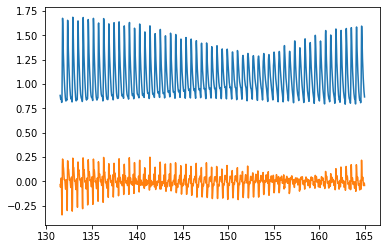

In [5]:
t, resy = fitter.get_residual()

plt.plot(t,y)
plt.plot(t,resy)
plt.show()

#### Print results

In [7]:
print('freq = ', pfit[0], err[0])

ncomponents = int((len(pfit)-1)/2)
for i in range(1, ncomponents + 1 ):
    print('A%d   = ' % i,   pfit[i],             err[i])
    print('Phi%d = ' % i,   pfit[i+ncomponents], err[i+ncomponents])

freq =  1.7620050802180858 2.9238024944838458e-06
A1   =  0.23895433654455855 0.0008538406449331871
Phi1 =  1.468292094353512e-14 0.04463978873882459
A2   =  0.11233229505865212 0.0007608096712029118
Phi2 =  5.534468112054411 0.006284508505289748
A3   =  0.06504536995316558 0.0007630668799451481
Phi3 =  5.006085365590188 0.013226007390356703


#### Calculate Fourier parameters

In [8]:
freq,period,P21,P31,R21,R31 = fitter.get_fourier_parameters()

print('freq = ',  freq.n,   freq.s)
print('period = ',period.n, period.s)
print('R21 = ',   R21.n,    R21.s)
print('R31 = ',   R31.n,    R31.s)
print('P21 = ',   P21.n,    P21.s)
print('P31 = ',   P31.n,    P31.s)

freq =  1.7620050802180858 2.9238024944838458e-06
period =  0.5675352535738595 9.417458602908177e-07
R21 =  0.47009942017815265 0.0035998539892943076
R31 =  0.27220836789892855 0.0033382055950770414
P21 =  5.534468112054381 0.08950049162848561
P31 =  5.006085365590144 0.13457088808249645


# Option 2-a: Prewhitening with given number of freqs __with__ y errors

In [9]:
# Initalize fitter
fitter = FourierFitter()

In [10]:
%%time
# Do the Fourier calculation and fitting w/out bootstrap error estimation

nfreq = 3  # Set to e.g. 9999 to fit all harmonics
pfit,err = fitter.fit_freqs( t,y, error=yerr,
                             nfreq = nfreq,
                             plotting = False,
                             minimum_frequency=None,
                             maximum_frequency=None,
                             nyquist_factor=1,
                             samples_per_peak=10,
                             bootstrap=False,ntry=100,sample_size=0.9, parallel=False,ncores=-1,
                             kind='sin')

CPU times: user 65.3 ms, sys: 5.24 ms, total: 70.5 ms
Wall time: 70 ms


/Users/batty/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:272: UserWarning: One of the errors is inf! Shifting light curve by half period to calculate errors...


## Option 2-b: Same with Bootstrap error estimation to get more reliable errorbars

In [12]:
%%time
# Do the Fourier calculation and fitting w/ bootstrap error estimation

nfreq = 3   # Set to e.g. 9999 to fit all harmonics
pfit,err = fitter.fit_freqs( t,y, error=yerr,
                             nfreq = nfreq,
                             plotting = False,
                             minimum_frequency=None,
                             maximum_frequency=None,
                             nyquist_factor=1,
                             samples_per_peak=10,
                             bootstrap=True,ntry=100,sample_size=0.9, parallel=False,ncores=-1,
                             kind='sin' )

/Users/batty/opt/miniconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Users/batty/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:305: UserWarning: One of the errors is too small! Shifting light curve by half period to calculate errors...


CPU times: user 1.26 s, sys: 11 ms, total: 1.27 s
Wall time: 1.27 s


#### Get residual light curve if needed

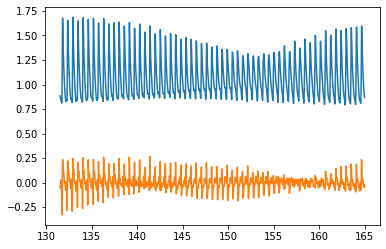

In [11]:
t, resy, err = fitter.get_residual()

plt.plot(t,y)
plt.plot(t,resy)
plt.show()

#### Print results

In [13]:
print('freq = ', pfit[0], err[0])

ncomponents = int((len(pfit)-1)/2)
for i in range(1, ncomponents + 1 ):
    print('A%d   = ' % i,   pfit[i],             err[i])
    print('Phi%d = ' % i,   pfit[i+ncomponents], err[i+ncomponents])

freq =  1.7619841569810293 3.113304056032256e-06
A1   =  0.23544095829939346 0.0007362921513235307
Phi1 =  1.2176260151919309e-14 0.04810687314340979
A2   =  0.10959152002872836 0.0007475793689538121
Phi2 =  5.537171965011364 0.005410636108013566
A3   =  0.06220322849893763 0.0007430549853488334
Phi3 =  4.98221500226248 0.011321447488064596


#### Calculate Fourier parameters

In [14]:
freq,period,P21,P31,R21,R31 = fitter.get_fourier_parameters()

print('freq = ',  freq.n,   freq.s)
print('period = ',period.n, period.s)
print('R21 = ',   R21.n,    R21.s)
print('R31 = ',   R31.n,    R31.s)
print('P21 = ',   P21.n,    P21.s)
print('P31 = ',   P31.n,    P31.s)

freq =  1.7619841569810293 3.113304056032256e-06
period =  0.5675419929503751 1.002807421179359e-06
R21 =  0.46547347080268275 0.00349300256892464
R31 =  0.2641988418168016 0.00326237261578689
P21 =  5.53717196501134 0.09636576133481138
P31 =  4.982215002262444 0.1447640023139389
